In [1]:
import os
import sys

import numpy as np
import math
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo as mc
import chirality_tools as chir
import energy as eg
from numba import jit
from numba_progress import ProgressBar

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Initialization

In [3]:
mu0 = (4*np.pi)*1e-7 * ureg.H/ureg.m
kb = 1.380649e-23 * ureg.J / ureg.K
kbT = (params['kb'] * params['sim_temp']).to(ureg.nm * ureg.pN).magnitude

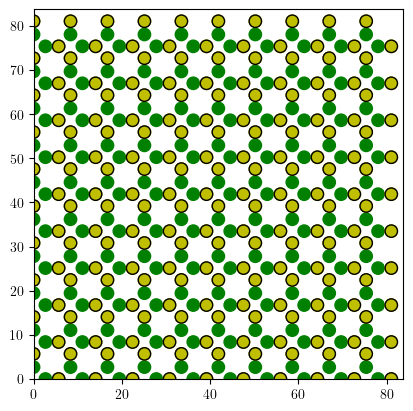

In [4]:
N = 10
a = params['lattice_constant']

sp = ice.spins()
sp.create_lattice('square', [N,N], lattice_constant=a ,border='periodic')

particle = ice.particle(radius=params['particle_radius'],
                        susceptibility=params['particle_susceptibility'],
                        diffusion=params['particle_diffusion'],
                        temperature=params['particle_temperature'],
                        density=params['particle_density']
)

trap = ice.trap(trap_sep=params['trap_sep'],
                height=params['trap_height'],
                stiffness=params['trap_stiffness']
)


col = ice.colloidal_ice(sp, particle, trap,
                       height_spread=0,
                       susceptibility_spread=0.1,
                       periodic=True)

particle_radius = params['particle_radius']
col.region = np.array([[0,0,-3*(particle_radius/a/N).magnitude],[1,1,3*(particle_radius/a/N).magnitude]])*N*a

col.display()

In [5]:
def is_accepted(dE,kbT):
    arg = dE/kbT
    if dE<0:
        return True
    else:
        r = np.random.rand()
        if r<np.exp(arg):
            return True
        else:
            return False

def metropolis(centers, dirs, rels, prefactor, mcsteps=1000):
    
    atoms = centers + rels 
    a = np.round(params['lattice_constant'].magnitude, 5) 
    Eold = eg.calculate_energy(prefactor, N*a, atoms)
    
    print(Eold)
    for i in tqdm(range(mcsteps)):
        dirsnew, relsnew, pos = mc.flip_loop(a,N,centers,dirs,rels)
        
        newatoms = centers + relsnew
        Enew = eg.calculate_energy(prefactor, N*a, newatoms)
        
        dE = Enew - Eold
        
        if is_accepted(dE,kbT):
            
            dirs = dirsnew.copy()
            rels = relsnew.copy()
            Eold = Enew
        else:
            Eold=Eold
    
    print(Eold)


In [7]:
centers, dirs, rels = mc.trj2numpy(col.to_ctrj())

B = 1*ureg.mT
m = np.pi * (2*params['particle_radius'])**3 *params['particle_susceptibility']*B/6/mu0
prefactor =  - (mu0*m**2/4/np.pi).to(ureg.pN * ureg.nm * ureg.um**3).magnitude

metropolis(centers, dirs, rels, prefactor, mcsteps=1000)

-3268.557715442385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 331.09it/s]

-3451.9643044539644


In [8]:
np.random.randint()

TypeError: randint() takes at least 1 positional argument (0 given)


# Import

In [6]:
fields = list(range(1,10+1))
datapath = '/media/frieren/BIG/stuckgs/data/metropolis/1M'

In [13]:
import re
all_files = os.listdir(datapath)
trj_files = [x for x in all_files if x.startswith('trj')]
vrt_files = [x for x in all_files if x.startswith('vertices')]
field_values = [re.search(r'(\d+\.\d+)', x).group(1) for x in vrt_files]
field_values

['10.0',
 '7.0',
 '5.0',
 '3.0',
 '2.5999999999999996',
 '2.3999999999999995',
 '2.1999999999999997',
 '2.8',
 '1.9999999999999998',
 '1.7999999999999998',
 '1.5999999999999999',
 '1.4',
 '1.2',
 '1.0',
 '0.30000000000000004',
 '0.7000000000000001',
 '0.6000000000000001',
 '0.9',
 '0.8',
 '0.5',
 '0.4',
 '0.2',
 '0.1',
 '0.0']

In [15]:
for i,field in tqdm(enumerate(field_values)):
    # importing the files
    TRJ_FILE = os.path.join(datapath,f'trj{field}.csv')
    VRT_FILE= os.path.join(datapath,f'vertices{field}.csv')
    trj = pd.read_csv(TRJ_FILE,index_col=['frame','id'])
    vertices = pd.read_csv(VRT_FILE,index_col=['frame','vertex'])

    # creating vertices object
    v = ice.vertices()
    v.vertices = vertices 
    v.vertices
    
    # getting the counts from the last frame
    last_frame = trj.index.get_level_values('frame').max()
    counts = ice.count_vertices(aux.classify_vertices(v.vertices))
    counts['field'] = [field]*len(counts)
    lf_counts = counts.loc[last_frame,:]
    
    # saving counts file
    if i==0:
        lf_counts.to_csv(os.path.join(datapath,'counts.csv'))
    else:
        lf_counts.to_csv(os.path.join(datapath,'counts.csv'),header=False,mode='a')

24it [00:50,  2.10s/it]


In [26]:
counts = pd.read_csv(os.path.join(datapath,'counts.csv'),index_col=['field','type'])
counts = counts.sort_index()
counts_vector = np.array([stuff.fraction.to_list() for B,stuff in counts.groupby('field')])
fields = counts.index.get_level_values('field').unique().to_list()

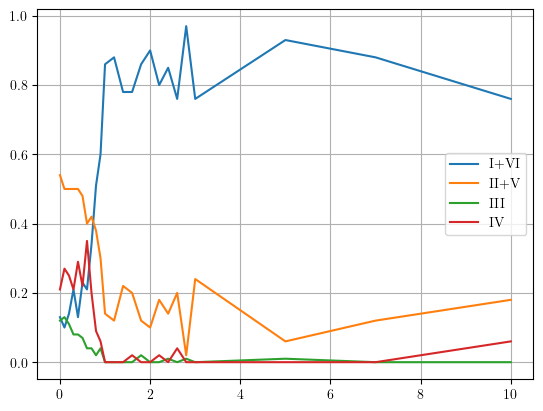

In [32]:

plt.plot(fields,counts_vector[:,0]+counts_vector[:,-1],label='I+VI')
plt.plot(fields,counts_vector[:,1]+counts_vector[:,-2],label='II+V')
plt.plot(fields,counts_vector[:,2],label='III')
plt.plot(fields,counts_vector[:,3],label='IV')

plt.grid()
plt.legend()
plt.show()

In [67]:
x = 1.0
xstr = str(x)
xstr = xstr.replace('.','p')
xstr

'1p0'

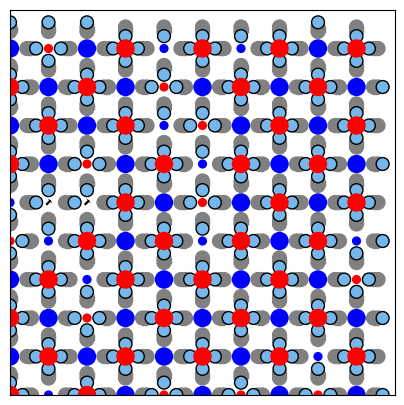

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

frame = last_frame
ice.draw_frame(trj, frame_no=frame,
               region=[0,N*a.magnitude,0,N*a.magnitude],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

v.display(ax,dpl_scale=0.5,dpl_width=2.5,circle_scale=0.5,sl=frame)
plt.show()

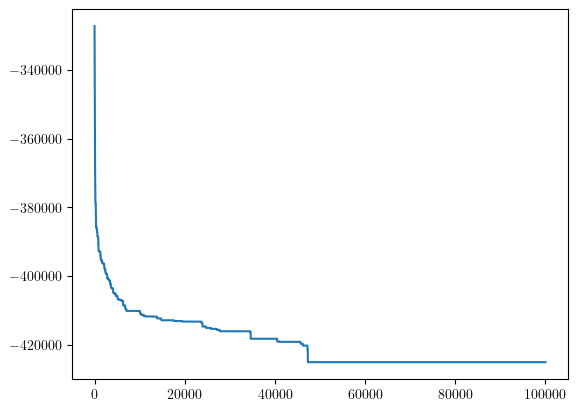

In [45]:
ENERGY_FILE = '/media/frieren/BIG/stuckgs/data/metropolis/energy10.csv'
enerki = pd.read_csv(ENERGY_FILE)
plt.plot(enerki.frame,enerki.energy)

In [62]:
enerki

,frame,energy
0,0.0,-327281.663508
1,1.0,-327697.226898
2,2.0,-328135.298331
3,3.0,-328358.406580
4,4.0,-330596.912702
...,...,...
99995,99995.0,-425131.139076
99996,99996.0,-425131.139076
99997,99997.0,-425131.139076
99998,99998.0,-425131.139076


In [61]:
fields = np.concatenate([np.arange(0,1,0.1), np.arange(1,3,0.2), np.array([3,5,7,10])])

24